# CatBoost Regressor

In [62]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Splitting dataset menjadi train dan test dengan perbandingan 8:2  
rumah123_df = pd.read_csv("../../data/rumah123_ready.csv")
X = rumah123_df.drop(columns=['price'])
y = rumah123_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
param_grid = {
    'iterations': [1500],       # >2000
    'learning_rate': [0.15],    # 0.15
    'depth': [7],               # 7
    'l2_leaf_reg': [2],         # 1, 3, 5
    'random_strength': [1],     # 1
    'bagging_temperature': [0.1], # 0.5
    'verbose': [0]
}

model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    # logging_level='Silent', 
    thread_count=-1
)

# Tangkap hasil grid search
grid_result = model.grid_search(
    param_grid,
    X=Pool(X_train_scaled, y_train),
    cv=3,
    partition_random_seed=42,
    refit=True,
    calc_cv_statistics=True,
    verbose=3
)

# Ambil best_params
best_params = grid_result['params']
print("Best parameters found:", best_params)



bestTest = 265.5830483
bestIteration = 1397

0:	loss: 265.5830483	best: 265.5830483 (0)	total: 4.62s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 278.1041632
bestIteration = 690

Training on fold [1/3]

bestTest = 273.5706015
bestIteration = 946

Training on fold [2/3]

bestTest = 272.7146384
bestIteration = 931

Best parameters found: {'bagging_temperature': 0.1, 'random_strength': 1, 'depth': 7, 'verbose': 0, 'learning_rate': 0.15, 'l2_leaf_reg': 2, 'iterations': 1500}


In [64]:
catboost_grid_best = CatBoostRegressor(**best_params)
catboost_grid_best.fit(X_train_scaled, y_train)

In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = catboost_grid_best.predict(X_train_scaled)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# rmse untuk data test
y_test_pred = catboost_grid_best.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE on training set:", rmse_train)
print("RMSE on testing set:", rmse_test)

RMSE on training set: 186.84428428266065
RMSE on testing set: 258.15476754870645


In [66]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("R2 on training set:", r2_train)
print("R2 on testing set:", r2_test)

R2 on training set: 0.8433900371299408
R2 on testing set: 0.7042397684434833


In [67]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(model, X, y, cv, scoring, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring=scoring)
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Number of Training Samples")
    plt.ylabel("neg_mean_squared_error")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing RMSE")

    plt.legend(loc="best")
    plt.show()

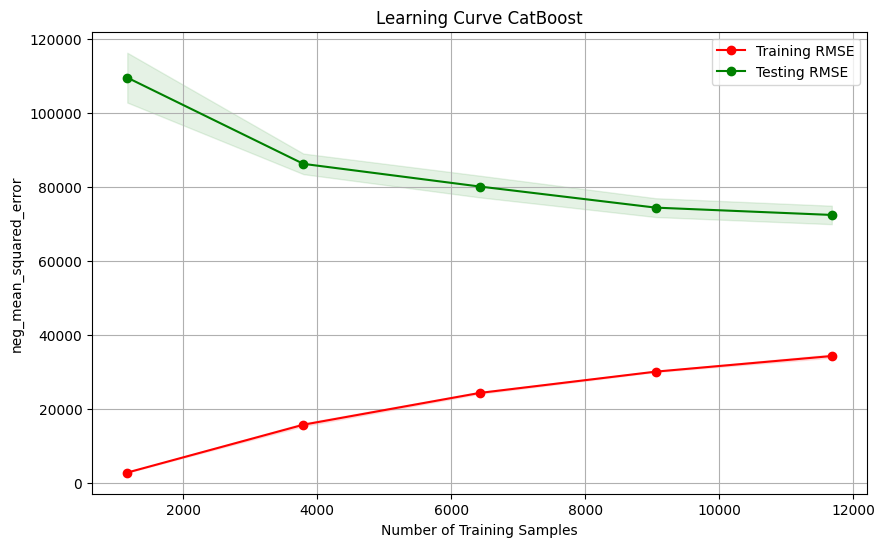

In [69]:
plot_learning_curve(catboost_grid_best, X, y, cv=5, scoring='neg_mean_squared_error', title="Learning Curve CatBoost")